<a href="https://colab.research.google.com/github/florisvdf/ai-environmental-impact/blob/main/self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing the heart of GPT
This notebook contains the entire architecture of a transformer model in the GPT family (see [nanoGPT](https://github.com/karpathy/nanoGPT) and [minGPT](https://github.com/karpathy/minGPT/tree/master) by Andrej Karpathy), minus the core feature of transformers; the self attention operation. You are tasked to implement this feature and validate that it works as intended by training on Shakespeare text and generating a sample of Shakespeare(-like) text.

This notebook is based on an assigment of WUR's 2024 Deep learning course. If you're interested in learning more about what happens under the hood of GPT, check out [Rens' deep learning repo](https://github.com/holmrenser/deep_learning).


# Architecture
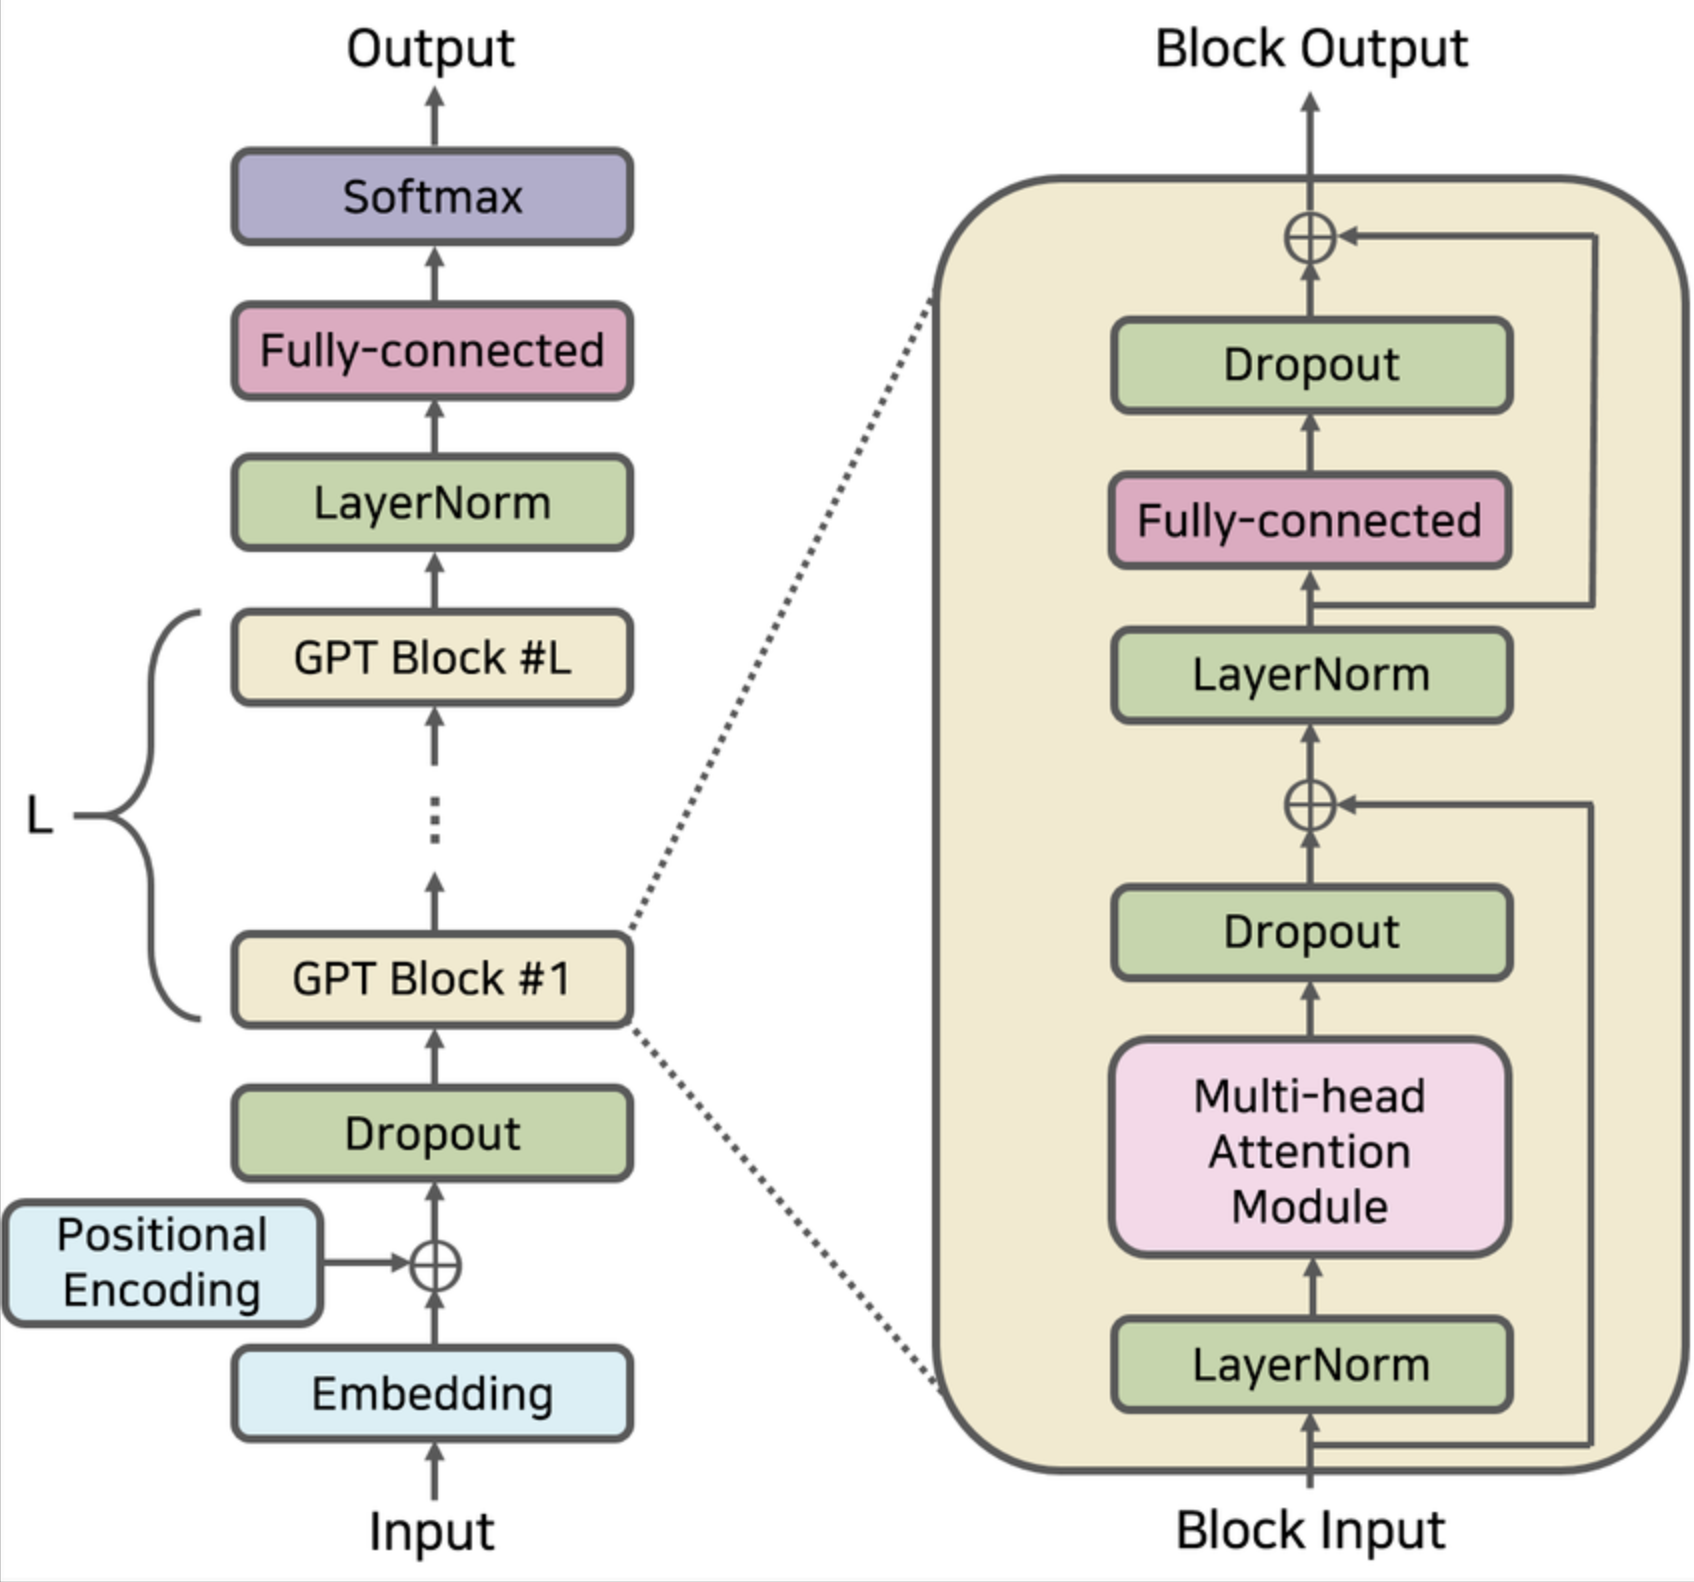

# Glossary
1. **Tensor**: A generalization of matrices to arbitrary dimensionalities. A scalar (1,), a vector (n,) and a matrix (n, m) are all instances of tensors. You can view a tensor of (m, n, o, p) as a matrix of (m, n) storing (o, p) matrices.
2. **Token**: Tokens are discrete units in sequences, such as letters, morhpemes, words, or even nucleotides and amino acids, represented as an integer that corresponds to their index in a vocabulary.
3. **Linear layer**: A neural network component that transforms inputs by multiplying them with a weight matrix. This weight matrix is learned during training to make the resulting projections informative for predictions. Linear regression can be viewed as a linear layer with a single neuron.
4. **Embedding**: Inputs transformed by a series of trained neural network components.
5. **Batch**: A collection of dataset samples that are presented to a model.
6. **Training step**: A series of actions performed to update the model by using a single batch.
7. **Loss function**: A function that compares model predictions to the ground truth data. It provides the signal for making updates to the model. The larger the loss function, the bigger the model update.
8. **Softmax**: A function that applies a normalization to a vector such that the sum of the scaled vector's elements is equal to one.
9. **Attention score**: A scalar that represents how important a given vector in the Value matrix is when computing representation for another given position in the sequence. For example, in the sentence "The building is tall and the sky is grey," the word "grey" has a high attention score relative to "sky" because they are contextually related.
10. **Attention matrix**: A matrix containing attention scores for all pairs of elements in an input sequence. For a sequence of length `n`, the attention matrix has shape `(n, n)`, where each element represents the attention score between two positions in the sequence.
11. **Dropout**: A technique used in deep learning where some layer outputs are ignored, in many cases resulting in better performance on new data. Out of scope for today.

In [1]:
import math
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

DEVICE = torch.device("CUDA" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device('mps') # 'mps' when you want to run this locally on an ARM macbook
print(f"Using {DEVICE}")

Using cpu


# Tokenizer

In [2]:
# @title Tokenizer
class CharacterTokenizer:
    """Character level tokenizer that enumerates unique characters in a training text"""
    def __init__(self, encoding_dict: dict[str, int]=None):
        if encoding_dict is None:
            self.encoding_dict = dict()
        else:
            self.encoding_dict = encoding_dict

    def __repr__(self):
        return f'CharacterTokenizer(vocab_size={self.vocab_size})'

    @property
    def decoding_dict(self) -> dict[int, str]:
        """Decoding dict is implemented as property to automatically sync with changed encoding dict"""
        return {token:char for char,token in self.encoding_dict.items()}

    @property
    def vocab_size(self) -> int:
        return len(self.encoding_dict)

    def get_vocab(self) -> dict[str, int]:
        return self.encoding_dict

    def train(self, data: str) -> None:
        """Train on a piece of text by enumerating unique characters"""
        chars = sorted(set(data))
        self.encoding_dict = {char:token for token,char in enumerate(chars)}

    def encode(self, data: str) -> list[int]:
        """Convert text to tokens"""
        return [self.encoding_dict.get(char, -1) for char in data]

    def decode(self, tokens: list[int]) -> str:
        """Convert tokens to text"""
        return ''.join(self.decoding_dict.get(token, '<unk>') for token in tokens)

# Data
We use the tiny shakespeare dataset to train a transformer on single character tokens to predict text that looks like shakespeare. All data is in one text file, which we download below.

In [3]:
#@title Dataset class

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, context_size: int=256):
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.context_size = context_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        context_size = self.context_size
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {context_size=})'

    @classmethod
    def from_textfile(cls, filename: str, context_size: int=256) -> 'CharacterDataset':
        """Load a textfile and automatically 'train' a character level tokenizer"""
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            tokenizer.train(data)
            return cls(data, tokenizer, context_size=context_size)

    def train_test_split(self, train_percentage: float=0.8) -> tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.tokenizer, self.context_size)

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.tokenizer, self.context_size)

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) - self.context_size

    def __getitem__(self, pos: int) -> torch.tensor:
        """Return tokens starting at pos up to pos + context_size, targets are shifted by one position"""
        # grab a chunk of block_size characters from the data
        chunk = self.data[pos:pos + self.context_size + 1]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # targets are shifted one position from input
        return tokens[:-1], tokens[1:]

In [4]:
!wget -nc https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-07-02 14:39:47--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-07-02 14:39:48 (24.9 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [5]:
dataset = CharacterDataset.from_textfile('./input.txt')
train_dataset,test_dataset = dataset.train_test_split()
print(f"Training set size: {len(train_dataset):,} \nTest set size: {len(test_dataset):,}")

Training set size: 892,059 
Test set size: 222,823


# Additive positional embedding
A component of the model that makes it aware of where any token resides in the sequence.

In [6]:
#@title AdditivePositionalEmbedding
class AdditivePositionalEmbedding(nn.Module):
    """Wrapper class to add positional encoding to already embedded tokens"""
    def __init__(self, context_size: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_size, embedding_dim=embedding_dim)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Add positional embeddings based on input dimensions, use residual connection"""
        pos = torch.arange(0, x.size(1), dtype=torch.long, device=x.device)
        return self.embedding(pos) + x

#PositionwiseMLP
A very small neural net of linear layers that mixes information otbained from the different heads of the transformer blocks.

In [7]:
#@title PositionWiseMLP
class PositionWiseMLP(nn.Module):
    """Position-wise feedforward MLP: simple multi-layer perceptron for position-wise exchange of information between channels"""
    def __init__(self, embedding_dim: int, dropout: float):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=4*embedding_dim),
            nn.ReLU(),
            nn.Linear(in_features=4*embedding_dim, out_features=embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.mlp(x)

# Exercise
Implementing deep learning models or components in PyTorch can be done in very minimal fashion. We subclass PyTorch's `nn.Module` class, assign all our model components as attributes in the `__init__` method and create a `forward` method that specifies how the components transform our inputs to yield the final outputs.

Your task is to implement the computations performed by the self attention operation in the `forward` method of the `MultiheadDotProductAttention` class. We can divide the self attention operation in three steps:

__Step 1__: Calculate the attention matrix from the key and query projections of each head. This consists of a single matrix multiplication step, followed by a normalization (see equation).

__Step 2__: Perform a columnwise softmax on each attention matrix.

__Step 3__: Multiply the attention matrix with the value projection.


## Hints
__Step 1__: The K, Q, V projections have shape (number of samples, number of heads, sentence length, head embedding dimension). We want to perform matrix multiplication over sentence length dimension and the head embedding dimension. The resulting attention maps will have a shape of (number of samples, number of heads, sentence length, sentence length). $d^{k}$ is the length of the embedded key, query and value vectors, and is stored by the `head_embedding_dim` variable. Pytorch understands python's builtin matrix multiplication operator, `@`.

__Step 2__: You can call the softmax function with `F.softmax`. `F.softmax` takes a `dim` argument that instructs it over which dimension to perform the softmax function. Example: If we apply softmax with dim=-1 (columns of the attention matrix), it means that for each row of the attention matrix, the softmax function is applied across all columns of the matrix. As a result, the sum of each row will be 1.

__Step 3__: Pytorch understands python's builtin matrix multiplication operator, `@`.

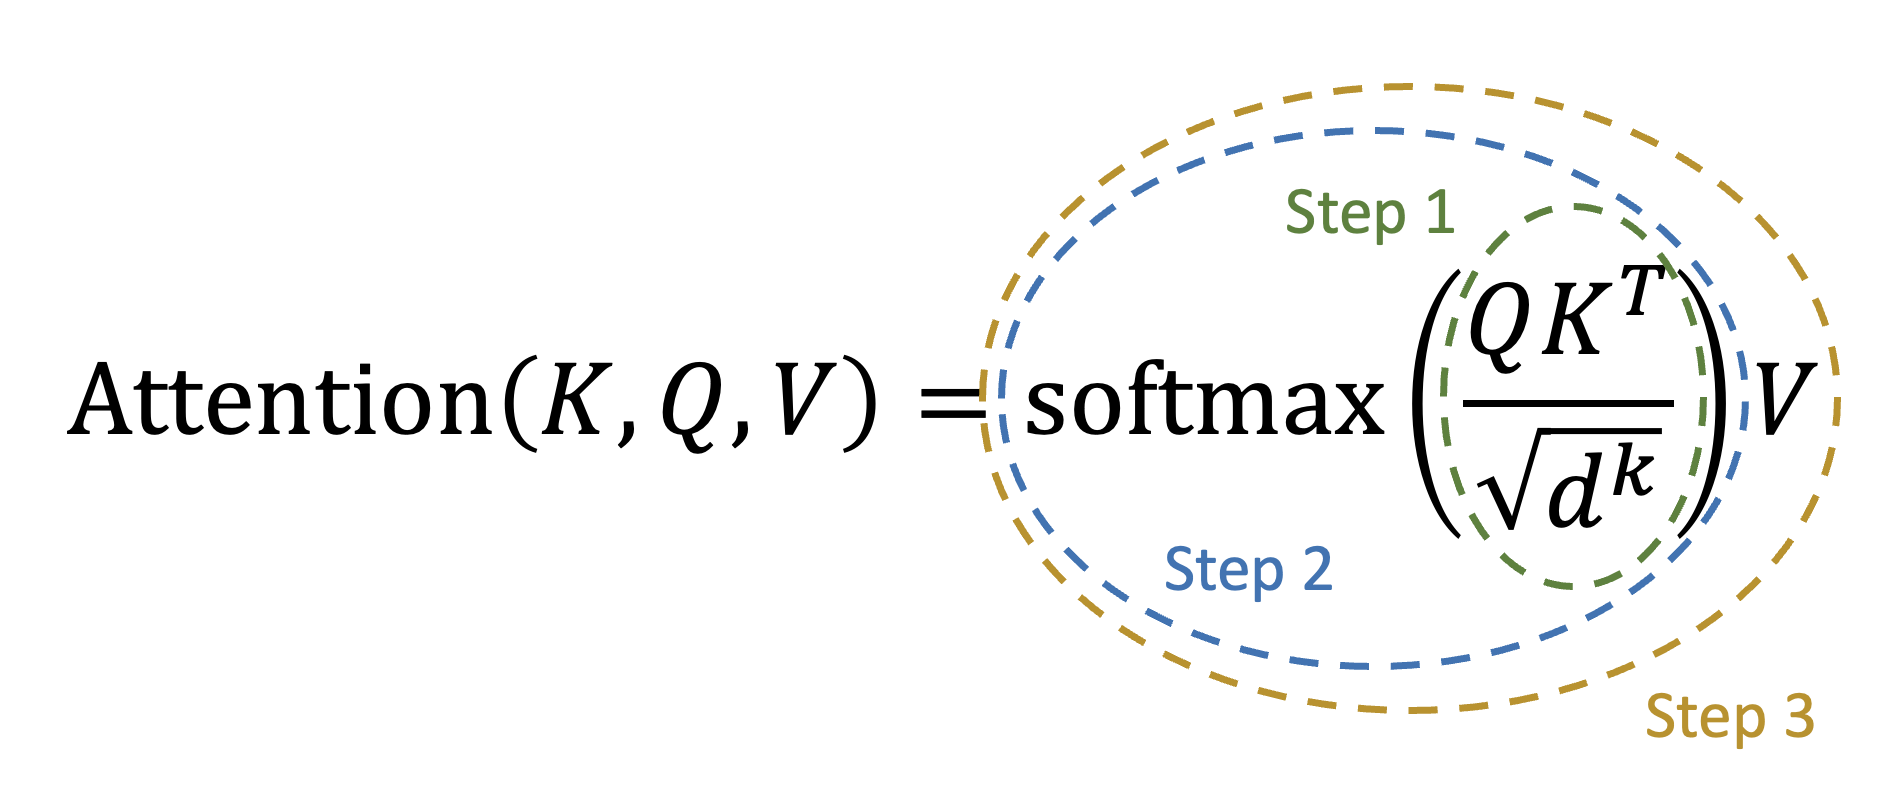



# Multihead dot product attention

In [12]:
class MultiheadDotProductAttention(nn.Module):
    """Multihead dot product softmax attention"""
    def __init__(self, embedding_dim: int, n_heads: int, dropout: float):
        super().__init__()
        if embedding_dim % n_heads != 0:
            raise Exception('n_heads must be dividable by n_embed')

        self.n_heads = n_heads

        # Linear layers that generate projections of the key, query and value triplets for all heads
        self.w_q = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_k = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_v = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        # Dropout (not important for today)
        self.attention_dropout = nn.Dropout(dropout)

        # A linear layer that generates a projection from the combination of the
        self.out_project = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.projection_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Calculate multihead attention, expects input of shape (batch, context_length, embedding_dim)"""
        # Tensor input shape: (number of samples, sentence length, projection length)
        batch_dim, context_length, embedding_dim = x.size()
        head_embedding_dim = embedding_dim // self.n_heads

        # calculate input projections and divide over heads
        # 'view' and 'transpose' reorder in subtly different ways and we need both
        # (B, L, n_heads, head_dim) -> (B, n_heads, L, head_dim)
        q = self.w_q(x).view(
            batch_dim,
            context_length,
            self.n_heads,
            head_embedding_dim
        ).transpose(1,2)
        k = self.w_k(x).view(
            batch_dim,
            context_length,
            self.n_heads,
            head_embedding_dim
        ).transpose(1,2)
        v = self.w_v(x).view(
            batch_dim,
            context_length,
            self.n_heads,
            head_embedding_dim
        ).transpose(1,2)

        ### IMPLEMENT STEP 1
        attention = ...

        # Masking attention scores that connect seen tokens to tokens not yet observed (only done in gpt-style models)
        mask = torch.triu(torch.ones(context_length, context_length, dtype=torch.bool, device=q.device), diagonal=1)
        attention = attention.masked_fill(mask, -torch.inf)

        ### IMPLEMENT STEP 2
        # Calculate attention scores over the column dimension (i.e. rows sum to 1)
        attention = ...

        # Randomly masking out some attention scores (not important for today)
        attention = self.attention_dropout(attention)

        ### IMPLEMENT STEP 3
        pred = ...

        # reshape multiple heads back into contiguous representation
        pred = pred.transpose(1, 2).contiguous().view(batch_dim, context_length, embedding_dim)

        # return linear projection
        return self.projection_dropout(self.out_project(pred))


# Solution

Solution:


```
### IMPLEMENT STEP 1
# Calculate the attention matrices
# Tensor transformation of k and query to attention matrix
# (batch_size, n_heads, L, head_size) x (batch_size, n_heads, head_size, L) -> (batch_size, n_heads, L, L)
attention = (q @ k.transpose(-2, -1)) / math.sqrt(head_embedding_dim)

# Masking attention scores that connect seen tokens to tokens not yet observed
mask = torch.triu(torch.ones(context_length, context_length, dtype=torch.bool, device=q.device), diagonal=1)
attention = attention.masked_fill(mask, -torch.inf)

### IMPLEMENT STEP 2
# Calculate attention scores over the column dimension (i.e. rows sum to 1)
attention = F.softmax(attention, dim=-1)

# Randomly masking out some attention scores (not important for today)
attention = self.attention_dropout(attention)

### IMPLEMENT STEP 3
# weight outputs with calculated attention
# (B, n_heads, L, L) x (B, n_heads, L, head_dim) -> (B, n_heads, L, head_dim)
pred = attention @ v
```

#TransformerBlock
Executes the DotProductSoftmaxAttention and FeedforwardMLP in order, both with layer normalization to keep our gradients well-behaved, and both with a residual connection to let the original signal flow through (which includes for example positional information).

In [13]:
#@title TransformerBlock
class TransformerBlock(nn.Module):
    """Transformer block that combines attention and FeedforwardMLP, both with layer normalization and residual connections"""
    def __init__(self, embedding_dim: int, n_heads:int, dropout:float):
        super().__init__()
        self.multihead_attention = MultiheadDotProductAttention(embedding_dim=embedding_dim, n_heads=n_heads, dropout=dropout)
        self.positionwise_mlp = PositionWiseMLP(embedding_dim=embedding_dim, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Calculate attention between tokens and communication between channels, both with residual connections"""
        attention_out = self.layer_norm1(x)
        attention_out = self.multihead_attention(attention_out)
        attention_out = self.dropout(attention_out)
        attention_out = x + attention_out

        mlp_out = self.layer_norm2(attention_out)
        mlp_out = self.positionwise_mlp(mlp_out)
        mlp_out = self.dropout(mlp_out)
        mlp_out = attention_out + mlp_out
        return mlp_out

# GPT
Combines all of the above functionality and adds dropout and layer normalization in a few places to help with generalization and prevent overfitting. In addition this implements the generate method so we can easily sample novel token sequences.

In [10]:
#@title GPT
class GPT(nn.Module):
    def __init__(
        self,
        context_size: int=None,
        vocab_size: int=None,
        n_layers: int=6,
        n_heads: int=8,
        embedding_dim: int=32,
        dropout: float=0.1
    ):
        super().__init__()
        self.context_size = context_size
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.transformer = nn.Sequential(
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
            AdditivePositionalEmbedding(context_size, embedding_dim),
            nn.Dropout(dropout),
            nn.Sequential(*[
                TransformerBlock(embedding_dim=embedding_dim, n_heads=n_heads, dropout=dropout)
                for _ in range(n_layers)
            ]),
            nn.LayerNorm(embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=vocab_size)
        )
        self.transformer[0].weight = self.transformer[-1].weight

        # initialize all weights
        self.apply(self._init_weights)

    def __repr__(self) -> str:
        context_size = self.context_size
        vocab_size = self.vocab_size
        n_attention_layers = self.n_layers
        n_heads = self.n_heads
        embedding_dim = self.embedding_dim
        dropout = self.dropout
        num_params = sum(p.numel() for p in self.parameters())
        return f'GPT({num_params=}, {context_size=}, {vocab_size=}, {n_attention_layers=}, {n_heads=}, {embedding_dim=}, {dropout=})'

    def forward(self, tokens: torch.tensor, targets: torch.tensor=None) -> torch.tensor:
        logits = self.transformer(tokens)
        loss = None if targets is None else F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        accuracy = None if targets is None else (logits.argmax(dim=-1) == targets).sum() / targets.numel()
        return logits,loss,accuracy

    def _init_weights(self, module: nn.Module) -> None:
        """Empirically this seems to be a good way to initialize"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate(self, sample_length: int=256) -> list[int]:
        """Generate sample tokens"""
        device = next(self.parameters()).device
        idx = torch.zeros(1, dtype=torch.long, device=device)

        for _ in trange(sample_length, desc='Sampling'):
            logits,_,_ = self(idx[-self.context_size:][None])
            logits = logits[0,-1,:]
            probs = F.softmax(logits, dim=0)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next])

        return idx.tolist()

# Generating sample text with the untraind model

In [14]:
model = GPT(context_size=dataset.context_size, vocab_size=dataset.tokenizer.vocab_size)
print(f"Dataset config: \n{dataset}\n")
print(f"Model config: \n{model}\n")
sample = model.generate()
print(dataset.tokenizer.decode(sample))

Dataset config: 
CharacterDataset(n_chars=1115394, vocab_size=65, context_size=256)

Model config: 
GPT(num_params=86625, context_size=256, vocab_size=65, n_attention_layers=6, n_heads=8, embedding_dim=32, dropout=0.1)



Sampling:   0%|          | 0/256 [00:00<?, ?it/s]


WFI3wF?W.HeToOknFHNDqq!D
hsEvf
N-HjZ
XfoicSbjmJERHqAEPMjK-bVdA?.lD3G!Od-pVbq'nZqa,GDoLqJEfhX:loqKRgKBKqcIdrv!KfcJ.G3VNEybgG rAeHpkhLFtVR$C WfjdQoi!?HPrS?jrh.Yh:!YnccKMYoSZ-SYw3.
xsNLJ3vqHnyzlfgpbn V$jMYfuHSp-!dRgg UgFSE-y!vSKjfMq,;&hkTTA.xulfAQYBJh.hZZ-Eff


In [15]:
#@title Training loop
def train_loop(model, optimizer, train_dataloader, test_dataloader):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for i, (train_x, train_y) in enumerate(tqdm(train_dataloader)):
        # forward the model
        _,train_loss,train_accuracy = model(train_x.to(DEVICE), train_y.to(DEVICE))

        # save losses on train and test every 20 iterations
        if i % 20 == 0:
            train_losses.append(train_loss.item())
            train_accuracies.append(train_accuracy.item())
            test_x, test_y = next(test_dataloader)
            _,test_loss,test_accuracy = model(test_x.to(DEVICE), test_y.to(DEVICE))
            test_losses.append(test_loss.item())
            test_accuracies.append(test_accuracy.item())

        # backprop and update the parameters
        model.zero_grad(set_to_none=True)
        train_loss.backward()

        # Prevent gradients from becoming too large
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    return train_losses, train_accuracies, test_losses, test_accuracies

In [16]:
#@title Plotting function
def plot_train_and_test_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    fig,[ax1, ax2] = plt.subplots(ncols=2, figsize=(12,4))
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_losses, label='test loss')
    ax1.legend()
    ax2.plot(train_accuracies, label='train accuracy')
    ax2.plot(test_accuracies, label='test accuracy')
    ax2.legend()
    return fig, [ax1, ax2]

# Training our model on the Shakespeare dataset
This should take no more than 5 minutes on CPU.

In [17]:
# Instantiating our dataset
dataset = CharacterDataset.from_textfile('./input.txt', context_size=64)
train_dataset, test_dataset = dataset.train_test_split()
print(f"Dataset config: \n{dataset}\n")

# Instantiating our model
model = GPT(context_size=dataset.context_size, vocab_size=dataset.tokenizer.vocab_size)
print(f"Model config: \n{model}\n")

# Moving our model to the GPU if available and setting our model in training mode
model.to(DEVICE)
model.train()

# Training our model by giving it batches of 16 samples from our dataset per step
train_steps = 2_000
batch_size = 16

# Creating loader objects that generate batches of samples
train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = iter(DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True),
    batch_size=batch_size,
))

# The optimizer that updates the model weights at the end of every training step
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

# Training our model
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(
    model,
    optimizer,
    train_dataloader,
    test_dataloader
)

Dataset config: 
CharacterDataset(n_chars=1115394, vocab_size=65, context_size=64)

Model config: 
GPT(num_params=80481, context_size=64, vocab_size=65, n_attention_layers=6, n_heads=8, embedding_dim=32, dropout=0.1)



  0%|          | 0/2000 [00:00<?, ?it/s]

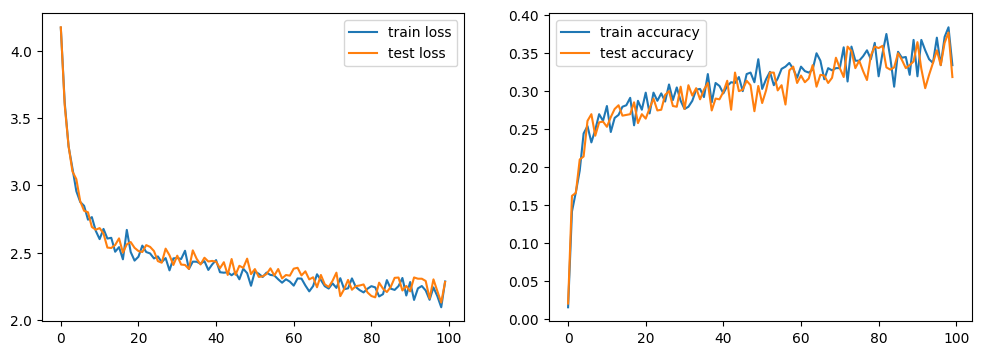

In [18]:
fig, ax = plot_train_and_test_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

## Evaluate
We let the trained model generate a piece of text that should somewhat resemble shakespeare. Compare to what was generated from the untrained model.

In [19]:
model.eval()
sample = model.generate()
print(dataset.tokenizer.decode(sample))

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]


Tind the the deim butind to wrerior,
Licky has, shed this dom thems driets ande thath,
Coord the that is inke hour  ffore,
Of Plead ther of lomr louck theat frand apes?

Sin AENTE:

; thou ford omaveve.
This the foth the mie.

ROUTBEREET:
O cheth, me-shove
